# Transformer (Attention Is All You Need) 구현하기 
- [code 참고 : transformer 구현하기(1/3)](https://paul-hyun.github.io/transformer-01/)
- [이론참고 : Attention is all you need 뽀개기](https://pozalabs.github.io/transformer/)

# 0. Settings

In [2]:
!pip install sentencepiece

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.2 MB 1.4 MB/s eta 0:00:01


In [81]:
import sentencepiece as spm
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# 1. Vocab
- sentencepiece로 미리 생성해둔 vocab을 이용해 입력 텍스트를 tensor로 변경

In [4]:
# vocab loading
vocab_file = "./data/kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

# input texts
lines = [
    "겨울은 추워요.",
    "감기 조심하세요."
]

# text to tensor
inputs = []
for line in lines:
    pieces = vocab.encode_as_pieces(line)
    ids = vocab.encode_as_ids(line)
    inputs.append(torch.tensor(ids))
    print(pieces)
    
# 입력 길이가 다르므로 입력 최대 길이에 맞춰 padding(0)을 추가
inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first = True, padding_value = 0)
# shape and value
inputs.size(), inputs

['▁겨울', '은', '▁추', '워', '요', '.']
['▁감', '기', '▁조', '심', '하', '세', '요', '.']


(torch.Size([2, 8]),
 tensor([[3159, 3533,  200, 3883, 3688, 3519,    0,    0],
         [ 206, 3534,   53, 3759, 3525, 3613, 3688, 3519]]))

# 2. Embedding
- Transformer의 임베딩은 아래의 두 가지 방법을 합해서 사용
1. Input embedding
2. Position Embedding

## 2-1. Input Embedding
- 임베딩은 입력 토큰을 벡터 형태로 변환함
### 1) 인풋에 대한 임베딩 값 input_embs구하기
- inputs(2,8)에 대한 임베딩 값 input_embs(2,8,128) shape을 가짐

In [5]:
n_vocab = len(vocab) # vocab count
d_hidn = 128 # hidden size
nn_emb = nn.Embedding(n_vocab, d_hidn) # embedding object

input_embs = nn_emb(inputs) # input embedding
input_embs.size()

torch.Size([2, 8, 128])

## 2-2. Position Embedding
1. 각 포지션 별로 angle 값 구하기
2. 구해진 angle 중 짝수 idx 값에 대한 sin값 구하기
3. 구해진 angle 중 홀수 idx 값에 대한 cos값 구하기

**position encoding function**
- [계산 참고](https://skyjwoo.tistory.com/entry/positional-encoding%EC%9D%B4%EB%9E%80-%EB%AC%B4%EC%97%87%EC%9D%B8%EA%B0%80)
- [positional encoding table 이해 참고](https://www.youtube.com/watch?v=dichIcUZfOw&t=639s)

In [6]:
"""sinusoid position embedding"""
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos

    return sinusoid_table

(64, 128)


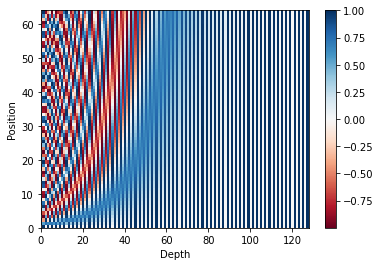

In [7]:
n_seq = 64
pos_encoding = get_sinusoid_encoding_table(n_seq, d_hidn)
print(pos_encoding.shape) # 크기 출력
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d_hidn))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### position embedding 값을 구하는 절차
1. 위에서 구해진 position encoding값을 이용해 position embedding 생성
    - 학습되는 값이 아니므로 freeze 옵션을 True로 설정
2. 입력 inputs과 동일한 크기를 갖는 positions 값 구하기
3. input값 중 pad(0)값 찾기
4. positions 값 중 pad 부분은 0으로 변경
5. positions 값에 해당하는 embedding 값 구하기

In [8]:
# 궁금해서 찍어봄
tmp = torch.arange(8)
tmp, tmp.expand(2,8), tmp.expand(2,8).contiguous() + 1

(tensor([0, 1, 2, 3, 4, 5, 6, 7]),
 tensor([[0, 1, 2, 3, 4, 5, 6, 7],
         [0, 1, 2, 3, 4, 5, 6, 7]]),
 tensor([[1, 2, 3, 4, 5, 6, 7, 8],
         [1, 2, 3, 4, 5, 6, 7, 8]]))

In [9]:
# 궁금해서 찍어봄 
inputs.eq(0)

tensor([[False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False, False, False]])

In [11]:
pos_encoding = torch.FloatTensor(pos_encoding)
nn_pos = nn.Embedding.from_pretrained(pos_encoding, freeze = True)

# torch.arange(end = 8, device = cpu, dtype = torch.int64)
positions = torch.arange(inputs.size(1), device = inputs.device, 
                         dtype=inputs.dtype).expand(inputs.size(0),
                                                    inputs.size(1)).contiguous() + 1
# inputs.eq(0) : 값이 0일 경우 True 반환
pos_mask = inputs.eq(0)
positions.masked_fill_(pos_mask, 0)
pos_embs = nn_pos(positions) # Position Embedding

inputs, positions, pos_embs.size()

(tensor([[3159, 3533,  200, 3883, 3688, 3519,    0,    0],
         [ 206, 3534,   53, 3759, 3525, 3613, 3688, 3519]]),
 tensor([[1, 2, 3, 4, 5, 6, 0, 0],
         [1, 2, 3, 4, 5, 6, 7, 8]]),
 torch.Size([2, 8, 128]))

- input_embs, pos_embs는 (2,8,128)로 동일함
- 두 값을 더한게 transformer에 입력할 Input값이 됨

In [12]:
inputs_sums = input_embs + pos_embs

# 3. Scaled Dot Product Attention
- [상세 계산 내용 참고](https://simpling.tistory.com/3)
1. MatMul : Q,K
2. Scale
3. Mask(opt.)
4. SoftMax
5. MatMul : V

### 입력값 : Query, Key, Value 그리고 Attention Mask로 구성 됨
- 입력값 중 K,V는 같은 값이어야 함
    - Q,K,V가 모두 동일할 경우 self attention이라 함

In [13]:
Q = K = V = inputs_sums # self attention

# inputs.eq(0) : pad(0) 부분만 True
# .unsqueeze(1) : size[2,8] -> 두 번째 차원에 1인 차원 추가 -> size[2, 1, 8]
# .expand(2,8,8)
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
attn_mask.size(), attn_mask[0]

(torch.Size([2, 8, 8]),
 tensor([[False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False,  True,  True]]))

## 3-1. MatMul : Q, K
### 각 단어 상호간에 가중치를 표현하는 테이블 생성
- Query와 Key의 행렬 계산은 Q * K-transpose 수행
    - 이는 내적 연산과 같은 과정으로 각 단어에 대한 attention score를 구할 수 있음 
- 내적 연산 결과는 -1~1사이의 값을 가짐
    - 어떤 쿼리와 키가 중요한 역할을 하고 있다면 attention block은 이들 사이의 내적 값을 키우는 방식으로 학습
    - 내적 값이 커지면 해당 쿼리와 키가 벡터 공간상 가까이 있을 가능성이 큼

In [14]:
scores = torch.matmul(Q, K.transpose(-1,-2))
scores.size(), scores[0]

(torch.Size([2, 8, 8]),
 tensor([[152.5829,  71.3071,  53.6365,  44.2965,  24.1472,  46.3893,  21.2868,
           21.2868],
         [ 71.3071, 214.0386,  75.3750,  55.4812,  70.3239,  76.8527,  43.8050,
           43.8050],
         [ 53.6365,  75.3750, 183.0883,  47.0940,  71.9082,  52.6489,  45.5789,
           45.5789],
         [ 44.2965,  55.4812,  47.0940, 177.3288,  58.1908,  40.6352,  60.8099,
           60.8099],
         [ 24.1472,  70.3239,  71.9082,  58.1908, 231.9337,  77.9936,  45.9691,
           45.9691],
         [ 46.3893,  76.8527,  52.6489,  40.6352,  77.9936, 211.8322,  43.9482,
           43.9482],
         [ 21.2868,  43.8050,  45.5789,  60.8099,  45.9691,  43.9482, 180.1961,
          180.1961],
         [ 21.2868,  43.8050,  45.5789,  60.8099,  45.9691,  43.9482, 180.1961,
          180.1961]], grad_fn=<SelectBackward>))

## 3-2. Scale
- 행렬 연산(내적) 후 벡터의 차원이 커지면 학습이 잘 안될 수 있으므로 스케일링 과정 거침
    - k-dimension에 루트를 취한 값으로 나누어 줌
- 가중치 편차가 scale 전과 비교하여 줄어듬을 확인할 수 있음

In [15]:
d_head = 64
scores = scores.mul_(1/d_head ** 0.5)
scores.size(), scores[0]

(torch.Size([2, 8, 8]),
 tensor([[19.0729,  8.9134,  6.7046,  5.5371,  3.0184,  5.7987,  2.6609,  2.6609],
         [ 8.9134, 26.7548,  9.4219,  6.9351,  8.7905,  9.6066,  5.4756,  5.4756],
         [ 6.7046,  9.4219, 22.8860,  5.8867,  8.9885,  6.5811,  5.6974,  5.6974],
         [ 5.5371,  6.9351,  5.8867, 22.1661,  7.2739,  5.0794,  7.6012,  7.6012],
         [ 3.0184,  8.7905,  8.9885,  7.2739, 28.9917,  9.7492,  5.7461,  5.7461],
         [ 5.7987,  9.6066,  6.5811,  5.0794,  9.7492, 26.4790,  5.4935,  5.4935],
         [ 2.6609,  5.4756,  5.6974,  7.6012,  5.7461,  5.4935, 22.5245, 22.5245],
         [ 2.6609,  5.4756,  5.6974,  7.6012,  5.7461,  5.4935, 22.5245, 22.5245]],
        grad_fn=<SelectBackward>))

## 3-3. Mask (Opt.)
- 자신보다 뒤에 있는 단어를 참고하지 않게 해주기 위해 mask해줌 
    - 전체 문장을 한 번에 행렬 형태로 입력하는 구조임
    - 따라서 mask를 하지않을 경우 자신보다 뒤에 있는 단어를 참고해서 단어를 예측하는 상황이 생길 수 있음
- Qeury 단어 뒤에 나오는 Key 단어들에 대해서 masking 진행

In [16]:
scores.masked_fill_(attn_mask, -1e9)
scores.size(), scores[0]

(torch.Size([2, 8, 8]),
 tensor([[ 1.9073e+01,  8.9134e+00,  6.7046e+00,  5.5371e+00,  3.0184e+00,
           5.7987e+00, -1.0000e+09, -1.0000e+09],
         [ 8.9134e+00,  2.6755e+01,  9.4219e+00,  6.9351e+00,  8.7905e+00,
           9.6066e+00, -1.0000e+09, -1.0000e+09],
         [ 6.7046e+00,  9.4219e+00,  2.2886e+01,  5.8867e+00,  8.9885e+00,
           6.5811e+00, -1.0000e+09, -1.0000e+09],
         [ 5.5371e+00,  6.9351e+00,  5.8867e+00,  2.2166e+01,  7.2739e+00,
           5.0794e+00, -1.0000e+09, -1.0000e+09],
         [ 3.0184e+00,  8.7905e+00,  8.9885e+00,  7.2739e+00,  2.8992e+01,
           9.7492e+00, -1.0000e+09, -1.0000e+09],
         [ 5.7987e+00,  9.6066e+00,  6.5811e+00,  5.0794e+00,  9.7492e+00,
           2.6479e+01, -1.0000e+09, -1.0000e+09],
         [ 2.6609e+00,  5.4756e+00,  5.6974e+00,  7.6012e+00,  5.7461e+00,
           5.4935e+00, -1.0000e+09, -1.0000e+09],
         [ 2.6609e+00,  5.4756e+00,  5.6974e+00,  7.6012e+00,  5.7461e+00,
           5.4935e+00, -1.

## 3-4. Softmax
- 0~1사이의 확률값으로 변환

In [17]:
attn_prob = nn.Softmax(dim=-1)(scores)
attn_prob.size(), attn_prob[0]

(torch.Size([2, 8, 8]),
 tensor([[9.9995e-01, 3.8706e-05, 4.2511e-06, 1.3227e-06, 1.0657e-07, 1.7182e-06,
          0.0000e+00, 0.0000e+00],
         [1.7847e-08, 1.0000e+00, 2.9675e-08, 2.4684e-09, 1.5783e-08, 3.5696e-08,
          0.0000e+00, 0.0000e+00],
         [9.3859e-08, 1.4210e-06, 1.0000e+00, 4.1429e-08, 9.2127e-07, 8.2959e-08,
          0.0000e+00, 0.0000e+00],
         [5.9993e-08, 2.4282e-07, 8.5107e-08, 1.0000e+00, 3.4071e-07, 3.7961e-08,
          0.0000e+00, 0.0000e+00],
         [5.2472e-12, 1.6854e-09, 2.0546e-09, 3.6987e-10, 1.0000e+00, 4.3963e-09,
          0.0000e+00, 0.0000e+00],
         [1.0438e-09, 4.7033e-08, 2.2827e-09, 5.0847e-10, 5.4242e-08, 1.0000e+00,
          0.0000e+00, 0.0000e+00],
         [4.6038e-03, 7.6835e-02, 9.5909e-02, 6.4373e-01, 1.0070e-01, 7.8223e-02,
          0.0000e+00, 0.0000e+00],
         [4.6038e-03, 7.6835e-02, 9.5909e-02, 6.4373e-01, 1.0070e-01, 7.8223e-02,
          0.0000e+00, 0.0000e+00]], grad_fn=<SelectBackward>))

## 3-5. MatMul atten_prov, V
- value와 행렬곱을 해줘서 각 context vector 구하기

In [18]:
context = torch.matmul(attn_prob, V)
context.size()

torch.Size([2, 8, 128])

### Scaled Dot Procudt Attention Class
- 위 절차를 하나의 클래스 형태로 구성하면 아래와 같음

In [27]:
"""scale dot product attention"""
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_head):
        super().__init__()
        self.scale = 1 / (d_head ** 0.5)
    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q,K.transpose(-1,-2)).mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        attn_prob = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn_prob, V)
        return context, attn_prob

In [46]:
# class를 이용하여 context vector, attention prob 구하기
attention = ScaledDotProductAttention(64)
Q = K = V = inputs_sums
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
context, attn_prob = attention.forward(Q,K,V,attn_mask)

# 4. Multi-Head Attention

In [51]:
Q = K = V = inputs_sums
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
batch_size = Q.size(0)
n_head = 2

## Multi Head Q, K, V
- Q, K, V를 여러개의head로 나누는 과정  
 **nn.Linear(in_features, out_features)**
- in_features : size of each input sample
- out_features : size of each output sample

In [61]:
W_Q = nn.Linear(d_hidn, n_head * d_head)
W_K = nn.Linear(d_hidn, n_head * d_head)
W_V = nn.Linear(d_hidn, n_head * d_head)

q_s = W_Q(Q).view(batch_size, -1, n_head, d_head).transpose(1,2)
k_s = W_K(K).view(batch_size, -1, n_head, d_head).transpose(1,2)
v_s = W_V(V).view(batch_size, -1, n_head, d_head).transpose(1,2)
print(q_s.size(), k_s.size(), v_s.size())

torch.Size([2, 2, 8, 64]) torch.Size([2, 2, 8, 64]) torch.Size([2, 2, 8, 64])


In [62]:
# attention mask 도 multi head로 변경
print(attn_mask.size())
attn_mask = attn_mask.unsqueeze(1).repeat(1, n_head, 1, 1)
print(attn_mask.size())

torch.Size([2, 8, 8])
torch.Size([2, 2, 8, 8])


### Attention
- scaled Dot product Attention

In [63]:
scaled_dot_attn = ScaledDotProductAttention(d_head)
context, attn_prob = scaled_dot_attn(q_s, k_s, v_s, attn_mask)
print(context.size())
print(attn_prob.size())

torch.Size([2, 2, 8, 64])
torch.Size([2, 2, 8, 8])


### Concat

In [66]:
# multi head를 한 개로 합침
context = context.transpose(1,2).contiguous().view(batch_size, -1, n_head * d_head)
context.size()

torch.Size([2, 8, 128])

### Linear
- 입력 Q와 동일한 shape을 가진 multi head attention이 구해짐

In [67]:
linear = nn.Linear(n_head * d_head, d_hidn)
output = linear(context)
output.size()

torch.Size([2, 8, 128])

### Multi head Attention Class
- 위 절차를 하나의 클래스 형태로 구성하면 아래와 같음

In [71]:
""" multi head attention """
class MultiHeadAttention(nn.Module):
    def __init__(self, d_hidn, n_head, d_head):
        super().__init__()
        self.d_hidn = d_hidn
        self.n_head = n_head
        self.d_head = d_head

        self.W_Q = nn.Linear(d_hidn, n_head * d_head)
        self.W_K = nn.Linear(d_hidn, n_head * d_head)
        self.W_V = nn.Linear(d_hidn, n_head * d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(d_head)
        self.linear = nn.Linear(n_head * d_head, d_hidn)
    
    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)

        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_head, 1, 1)

        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        # (bs, n_head, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_head * self.d_head)
        # (bs, n_head, n_q_seq, e_embd)
        output = self.linear(context)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob

# 5. Masked Multi-Head Attention
- Multi-Head Attention과 attention mask를 제외한 부분은 모두 동일

In [69]:
""" attention decoder mask """
def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1) # upper triangular part of a matrix(2-D)
    return subsequent_mask


Q = K = V =inputs_sums

attn_pad_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_pad_mask[1])
attn_dec_mask = get_attn_decoder_mask(inputs)
print(attn_dec_mask[1])
attn_mask = torch.gt((attn_pad_mask + attn_dec_mask), 0)
print(attn_mask[1])

batch_size = Q.size(0)
n_head = 2

tensor([[False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False]])
tensor([[0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[False,  True,  True,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True,  True,  True],


### Multi-head Attention
- 위와 동일하므로 클래스 호출

In [72]:
attention = MultiHeadAttention(d_hidn, n_head, d_head)
output, attn_prob = attention(Q, K, V, attn_mask)
print(output.size(), attn_prob.size())

torch.Size([2, 8, 128]) torch.Size([2, 2, 8, 8])


# 6. FeedForward
$FFN(x)=max(0,xW_1+b_1)W_2+b_2$
- The feed-forward layer is weights that is trained during training and the exact same matrix is applied to each respective token position.
- Since it is applied without any communcation with or inference by other token positions it is a highly parallelizable part of the model.
- The role and purpose is to process the output from one attention layer in a way to better fit the input for the next attention layer.

### f1 : Linear
$f_1 = xW_1+b_1$

In [78]:
conv1 = nn.Conv1d(in_channels=d_hidn, out_channels=d_hidn * 4, kernel_size=1)
# (bs, d_hidn * 4, n_seq)
ff_1 = conv1(output.transpose(1, 2))
print(ff_1.size())

torch.Size([2, 512, 8])


### f2
$f_2 = max(0,f_1)$
### Activation
- relu or gelu
- 논문에는 relu를 사용했지만 이후 gelu를 사용할 때 더 성능이 좋다는 것이 발견됨

In [82]:
# active = F.relu
active = F.gelu
ff_2 = active(ff_1)

### f3(Linear)
$f_3 = f_2w_2 + b_2$

In [83]:
conv2 = nn.Conv1d(in_channels=d_hidn * 4, out_channels=d_hidn, kernel_size=1)
ff_3 = conv2(ff_2).transpose(1, 2)
print(ff_3.size())

torch.Size([2, 8, 128])


### PoswiseFeedForwardNet
- Multi-Head Attention과 attention mask를 제외한 부분은 모두 동일

In [84]:
""" feed forward """
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_hidn):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_hidn * 4, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_hidn * 4, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = F.gelu

    def forward(self, inputs):
        # (bs, d_ff, n_seq)
        output = self.active(self.conv1(inputs.transpose(1, 2)))
        # (bs, n_seq, d_hidn)
        output = self.conv2(output).transpose(1, 2)
        # (bs, n_seq, d_hidn)
        return output